<a href="https://colab.research.google.com/github/Anomaly1702/NLP_Ass3/blob/main/Copy_of_Becky_assign3_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 1 
### \<Anubhav DattaGupta> \<a1812913>

### 1. Reading dataset and pre-processing

#### 1a)
In this Assignment we Read data from the **COVID-19 Open Research Dataset Challenge (CORD-19)** available in https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge.From which we subsample over 1,000,000 scholarly articles, including over 400,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. to get 10,000 random articles which are considered as dataset and used to create a factoid based question answering system that can find relevant article snippets matching a simple fact-based query in natural language.

* Plan followed for this assignment

1. Subsampling and downloadind data from kaggle COVID-19 dataset
2. Pre-processing the sampeled articles
3. Finding and extracting Named Entities within the articles, Creating a KnowledgeBase to link entity with associate names
4. Developing and inverted index for faster query processing
5. Evaluating MRR of the model 
7. Creating an interactive interface for user
7. Analyse the results

#### 1b)
The Data subsampling and reading can be found submitted Data.ipynb this file was run as a kaggle notebook on kaggle server to randomly select 10,000 articles. which were then exported as csv into covid_articles.csv. We extract
* paper_id
* body_text
* authors
* title
 <br />and use these to create a simple factoid based question answering system.

In [ ]:
# from gensim.models import Word2Vec

In [1]:
# Import Libraries
import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!pip install spacy_fastlang
!pip install transformers
!pip install SentencePiece
import torch
import numpy as np
import pandas as pd
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords #Importing Stop Words
#Tokenize the words
nltk.download('punkt')
from nltk.tokenize import word_tokenize #to TOkenize the words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


import spacy
from spacy import displacy
from tqdm import tqdm
import spacy_fastlang

import os
import re
import time
# !pip install --upgrade gensim
from gensim.models import Word2Vec
from tqdm import tqdm

tqdm.pandas()


import pprint
import pickle 
# !python -m spacy download en_core_web_md
# !pip install -U spacy[cuda92]
# !pip install spacy-language-detection
# !pip install spacy_fastlang
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/NLP/Ass3/'

#Reading the Dataset
article_df = pd.read_csv(data_dir + 'md_pmc_covid_articles.csv')
#removing repeated index column
article_df = article_df.drop(['Unnamed: 0'], axis=1)
# # # article_df.head(5)
proc_article_df = pd.read_csv(data_dir + 'Processed_covid_articles.csv')
#removing repeated index column
proc_article_df = proc_article_df.drop(['Unnamed: 0'], axis=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 400.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395639 sha256=4c589ce8d8897eb2596ec878ddd492724491786daa96c7b645dc45dd0d4b5355
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.9 MB/s eta 0:00:00
L

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
# !pip install spacy_fastlang
# import spacy_fastlang
lang_detect = spacy.load("en_core_web_sm")
lang_detect.add_pipe('language_detector')

In [ ]:
article_df.head()

,paper_id,body_text,authors,title,abstract
0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...
1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...
2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...
3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...
4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...


In [ ]:
#Detecting Articles of different Languages in our Datset
article_df['Language'] = [lang_detect(i)._.language for i in article_df['title']]
print(article_df['Language'].unique())

['en' 'lv' 'es' 'de' 'fr' 'cs' 'zh' 'lt' 'nl' 'it' 'pt' 'oc' 'id' 'sl'
 'th' 'ms' 'ar' 'fi' 'ca' 'ja' 'la' 'sr' 'pl']


In [ ]:
#Filtering and considering only english articles 
fltr_article_df = article_df[article_df['Language'] == 'en']
print(fltr_article_df['Language'].unique())

['en']


In [ ]:
fltr_article_df.head()

,paper_id,body_text,authors,title,abstract,Language
0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...,en
1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...,en
2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...,en
3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...,en
4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...,en


In [ ]:
#Now Considering only 4500 articles for our system
fltr_article_df = fltr_article_df[0:4500]

In [ ]:
fltr_article_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4614
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   4500 non-null   object
 1   body_text  4500 non-null   object
 2   authors    4500 non-null   object
 3   title      4500 non-null   object
 4   abstract   4500 non-null   object
 5   Language   4500 non-null   object
dtypes: object(6)
memory usage: 246.1+ KB


#### 1c) Pre-processing the Data

* To process the data using the reference provided below the Punctuation was removed along with the Non-alpha numeric characters, Stop words were removed and words were Lemmatized.<br/>
* Instead of keeping text as Bag of Words (BOW) the word tokens were then rejoined to form a single string representing the entire body text to reduce processing time for the text.<br/>
* The above mentioned pre- processing steps are done in order to reduce the noise in the data and help us during the Named Entity Recognition part of the project, cleaning and processing the text helps in reducing time required for processing ad helps in reducing noise in the data. <br/>

In [2]:
def preprocess(text,flag=0):

    # define regular expressions for common citation styles
    apa_regex = r"\(\d{4}\)"
    mla_regex = r"\(\w+\s\d+\)"
    ieee_regex = r"\[\d+\]"

    # define a regular expression to match references
    ref_regex = r"\[\d+\]"

    #Remove punctuation and all non-alphanumaric characters
    remove = string.punctuation.replace('.', '')
    rm_punct = [line.translate(line.maketrans('', '', remove)) for line in text]

    # remove APA-style citations
    text = [re.sub(apa_regex, "", i)for i in rm_punct]

    # remove MLA-style citations
    text = [re.sub(mla_regex, "", i)for i in text]

    # remove IEEE-style citations
    text = [re.sub(ieee_regex, "", i)for i in text]

    # remove references
    text = [re.sub(ref_regex, "", i)for i in text]

    # Tokenize the sentences
    token_words = [word_tokenize(j) for j in text]

    # #Remove all non-alphanumaric characters
    # rm_nonalpha = [[re.sub(r'[^a-zA-Z0-9]','',i)for i in line ] for line in token_words]

    #Remove Stop words
   #  stop_words = set(stopwords.words('english'))
    custom_stop_words = ['et','al','"','’','“','”','usepackageamsfonts','usepackageamssymb','usepackageamsmath','usepackagewasysym',
 'usepackageamsbsy','usepackagemathrsfs','usepackageupgreek','setlengthoddsidemargin69pt']
    stop_words = set(stopwords.words('english') + custom_stop_words)
    
    rm_stp  = [[word for word in line if word.lower() not in stop_words]for line in token_words]

    #Performing Lemmatization and lowering of words
    text_ver3 = [[lemmatizer.lemmatize(word.lower()) for word in line]for line in rm_stp]

    #Reconstructing into sentences
    text_ver1 = [" ".join(word) for word in text_ver3 if word != '']

    return text_ver1

In [ ]:
#Processing the Body_text and titles from the sampeled articles
proc_bdy = preprocess(fltr_article_df['body_text'])
# proc_title = preprocess(fltr_article_df['title'])

#Creating a new Dataframe with processed body and title 
proc_article_df = fltr_article_df.copy()
proc_article_df['body_text'] = proc_bdy
# proc_article_df['title'] = proc_title
proc_article_df.head()

#Storing the Datframe for later use
# proc_article_df.to_csv("Processed_covid_articles.csv")
#Reading form Dataframe to save time
# proc_article_df = pd.read_csv('Processed_covid_articles.csv')
#removing repeated index column
# proc_article_df = proc_article_df.drop(['Unnamed: 0'], axis=1)

,paper_id,body_text,authors,title,abstract,Language
0,PMC8524215,cancer prevalent cause mortality world common ...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...,en
1,PMC7698314,sarscov2 virus responsible covid19 disease fir...,"['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...,en
2,PMC8050998,artificial intelligence ai methodology compute...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...,en
3,PMC7581283,common feature patient admitted coronavirus di...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...,en
4,PMC7392455,coronavirus disease covid19 caused severe acut...,"['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...,en


In [3]:
article_df.head()

,paper_id,body_text,authors,title,abstract
0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...
1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...
2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...
3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...
4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...


In [4]:
proc_article_df.head()

,paper_id,body_text,authors,title,abstract,Language
0,PMC8524215,cancer prevalent cause mortality world common ...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",implementation vaccinomics insilico approach c...,68591 One of the most common gynecologic ca...,en
1,PMC7698314,sarscov2 virus responsible covid19 disease fir...,"['Enrique Casalino ', 'Christophe Choquet ',...",analysis emergency department visit hospital a...,813557 ED-visits and through-ED admissions ...,en
2,PMC8050998,artificial intelligence ai methodology compute...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",interventional radiology exmachina impact arti...,757155 Artificial intelligence (AI) is a br...,en
3,PMC7581283,common feature patient admitted coronavirus di...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",automatic oxygen titration o2matic® patient ad...,942009 INTRODUCTION: Patients with coronavi...,en
4,PMC7392455,coronavirus disease covid19 caused severe acut...,"['Daniel O. Griffin ', 'Alexandra Jensen ', '...",pulmonary embolism increased level ddimer pati...,843714 We report 3 patients with coronaviru...,en


#### 1 c) Exploring the Processed Data
Upon exploring the unique words in our processed Body text for 10,000 articles we found 'et','al','1','2' as highly freqeunt , BUt these words can be considered as noise since they porvide no informational value, to remove these Stop words was updated to include and filter these<br/>
Most frequent word as appearing in the articles is 'patient'.

In [ ]:
#Showing Unique words in Processed Body text in all of articles
def unique_dict(data):
  uniqe_version = {}
  for line in data:
    split_ln  = line.split()
    for j in split_ln :  
      if j in uniqe_version.keys():
          uniqe_version [ j ] += 1
      else :
          uniqe_version [ j ] = 1
  return uniqe_version

total_uniq_words = unique_dict(proc_article_df['body_text'])


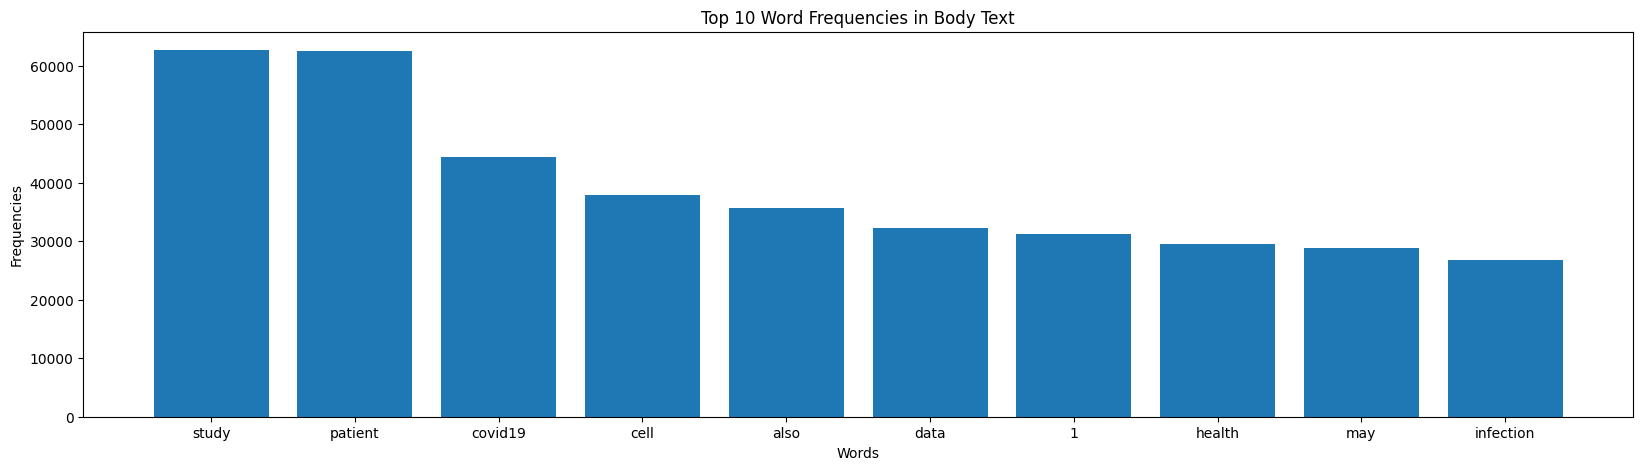

In [ ]:
# Sort the dictionary by frequency in descending order
sorted_dict = {k: v for k, v in sorted(total_uniq_words.items(), key=lambda item: item[1], reverse=True)}

# Extract the top 10 frequencies
top_freq = [freq for word, freq in list(sorted_dict.items())[1:11]]

# Extract the top 10 words
top_words = [word for word, freq in list(sorted_dict.items())[1:11]]

# Plot a bar chart of the top 10 frequencies
plt.figure(figsize=(20,5))
plt.bar(top_words, top_freq)
plt.title('Top 10 Word Frequencies in Body Text')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.show()

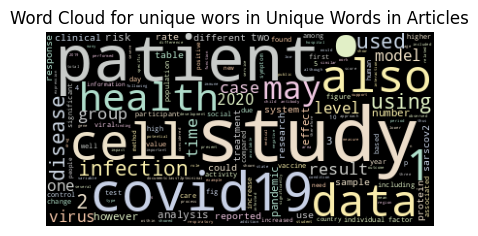

In [ ]:

#Word Cloud for unique words any dataset
def disp_wordCloud(title,dict,max_words=1000):
  plt.figure(figsize=(5,6))
  wordcloud = WordCloud (background_color="black",max_words=1000).generate_from_frequencies (dict)
  plt.imshow ( wordcloud , interpolation= 'bilinear' ) 
  plt.axis ( "off" ) 
  plt.title ( f"Word Cloud for unique wors in {title}" ) 
  plt.imshow (wordcloud.recolor(colormap='Pastel2', random_state=17), alpha=0.98)

title = "Unique Words in Articles"
disp_wordCloud(title,sorted_dict,max_words=1000)

#### 1.d) Answer

In pre-processing step, we removed stopwords, punctuations and lemmatized the words. 

* Remove punctuation and all non-alphanumeric characters from the input text using the translate() method and string.punctuation.

* Tokenize the sentences using the word_tokenize() function from the nltk library is used to split the text into individual words.

* Removing all non-alphanumeric characters from the tokens using regular expressions and the re library.

* Removing stop words. The set() function is used to create a set of English stop words from the nltk library. The noise discovered during dataset exploration is added to stop wards to filter them out.

* Performing lemmatization and lowercasing of the remaining words. The lemmatizer object from the nltk library is used to convert words to their base form (lemmas), and the lower() method is used to convert all remaining words to lowercase.

* Reconstruct the preprocessed sentences. The individual words are joined back together using the join() method with a space separator.


### 2. Named Entity Recognition and Knowledge Base

#### 2b) Knowledge Base

**Knowledge Base** is a structured database that contains a collection of facts in the form <subject, relation, object> , where each fact can have properties attached called qualifiers.

* ReVerb is a program that automatically identifies and extracts binary relationships from English sentences.Using reverb to create a KB extracting Entities and their relations from body text of articles and storing them into a tuple.

* The KB formed here will be used in the latter stages to filter the articles to find articles relevant to the query asked by the user.

In [ ]:
#Combining the pre_proc body text and storing into a file for input to Reverb
# all_text = " ".join(proc_article_df['body_text'])
# path = data_dir + 'Reverb_Prod_data.txt'
# with open(path, 'w') as f:
#     f.write(all_text)
#     f.close()

#Run Reverb on the Processed BOdy text for 5000 articles
# !java -Xmx512m -jar reverb-latest.jar Reverb_Prod_data.txt >> Reverb_input_5000.txt 

In [5]:
'''
Function to parse thoough reverb output to extract entity and relations
and storing the output in (Entity1,Relation,Entity2) format 
'''
path = data_dir + 'Reverb_input_5000.txt'
def extract_entity_relations(filepath=path):
    all_relations = []
    entity1 = []
    entity2 = []
    with open(filepath, 'r',encoding='latin') as f:
        x = [line.strip() for line in f.readlines()]
    f.close()
    for i in x:
        i = i.split('\t')
        entity1.append(i[-3])
        entity2.append(i[-1])
        all_relations.append((i[-3].replace("#", "").strip(),i[-2].replace("#", "").strip(),i[-1].replace("#", "").strip()))
    return all_relations,entity1,entity2

In [ ]:
# all_relations,entity1,entity2 = extract_entity_relations()
# len(all_relations)

In [6]:
import spacy
import matplotlib.pylab as plt
import networkx as nx

all_relations,entity1,entity2 = extract_entity_relations()

# Display Knowledge graph/knowledge base for 5 different entities
# Show a maximum of 3 relations per entity
total = 4
count = 0
print("Entity 1", "<--", "Relation", "-->", "Entity 2")
print("----------------------------------------------")
for entities in all_relations[0:50]:
    print(entities[0], "<--", entities[1], "-->", entities[2])



Entity 1 <-- Relation --> Entity 2
----------------------------------------------
exercise classified resistance flexibility <-- endurance --> balance etc
pandemic outbreak fear anxiety <-- spread across --> population germany
pandemic <-- result --> death worldwide
first evolution model cov proposed bat covs <-- serve --> gene source covs
 <-- cause --> common cold infection
common cold infection <-- lead --> acute lower respiratory tract infection exacerbate chronic pulmonary disease asthma
novel coronavirus ncov <-- emerge --> huanan wet food market livestock animal
herd immunity overall simulation pandemic <-- depend --> efficacy time course immunity
morbidity mortality <-- vary across --> country world
state <-- confirm --> case  death india
 <-- confirm --> case  death brazil  confirmed case
direct contact <-- contaminate --> object surface
2020.1 approach <-- receive --> international praise criticism
 <-- agree --> presence internet technology
presence internet technology <-- p

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128 (\x80) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


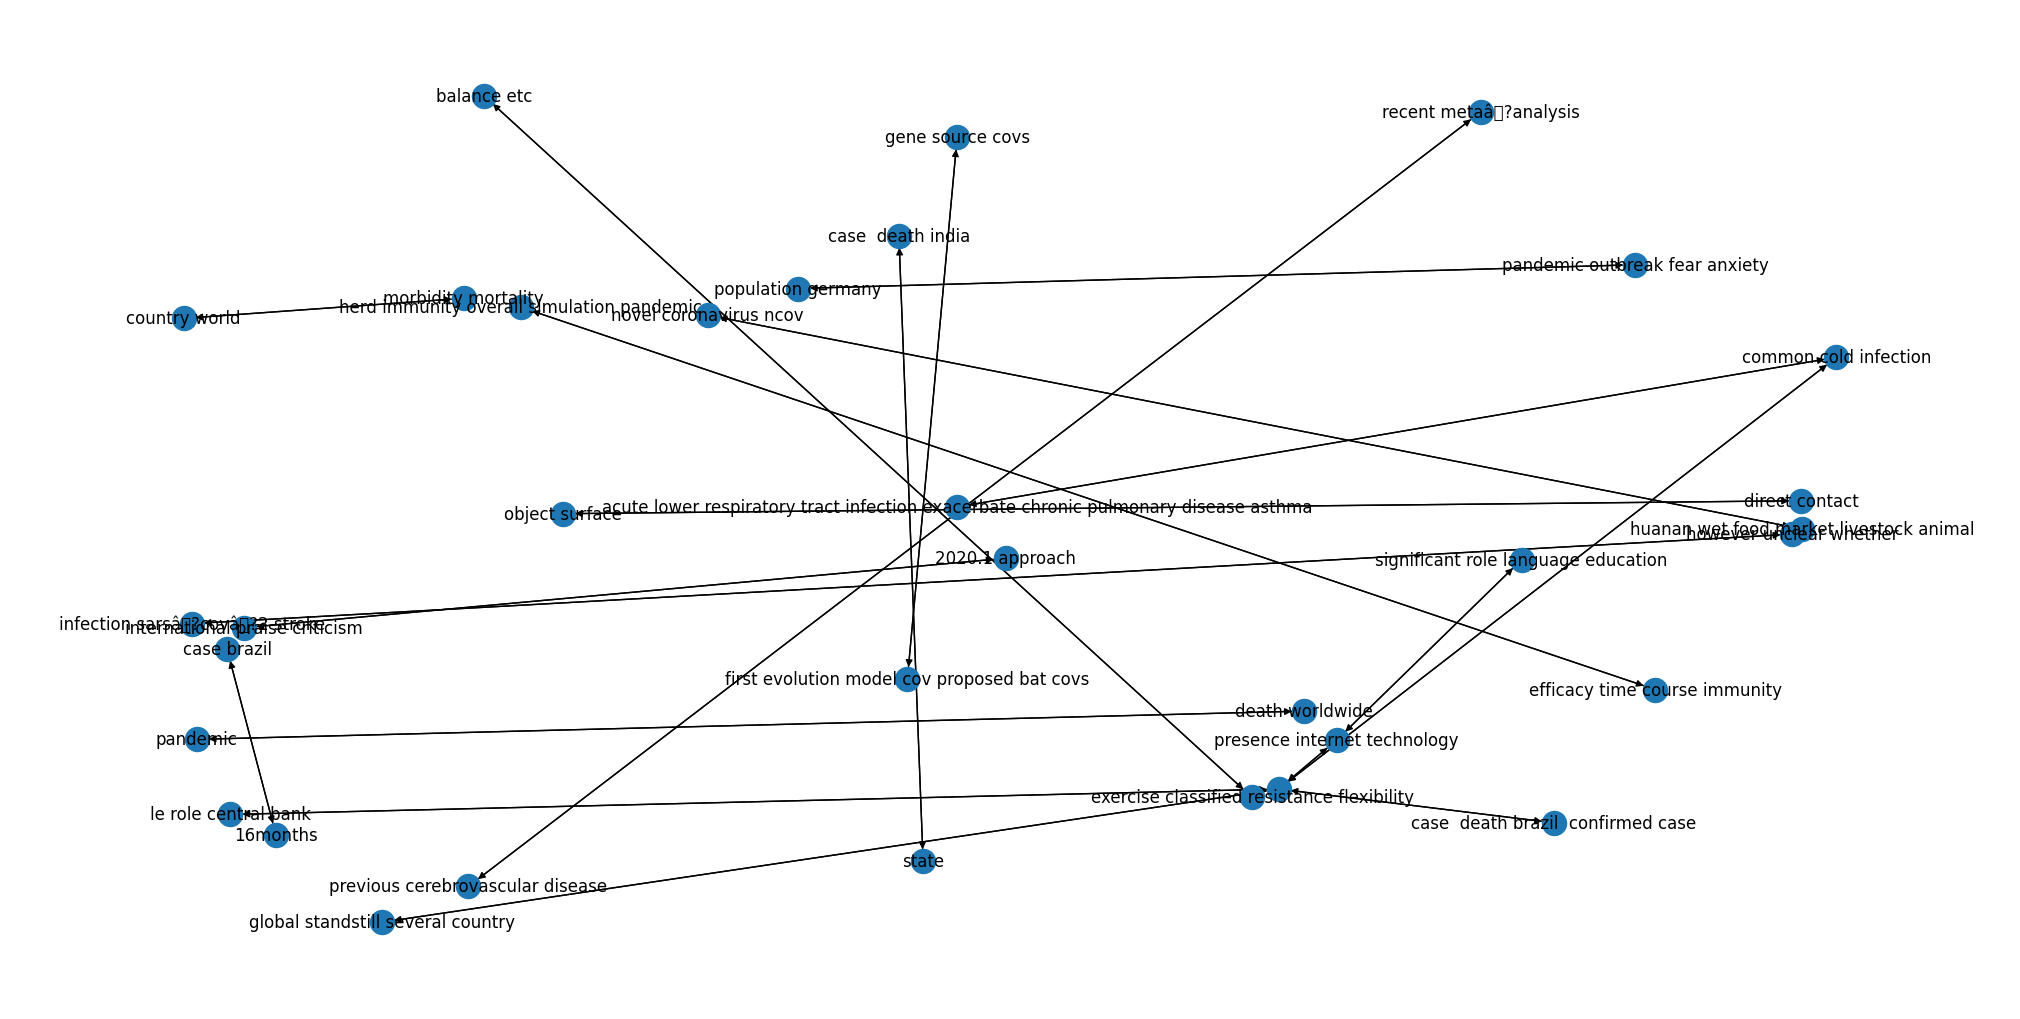

In [ ]:
'''
Function to visualize the Knowledge base
'''
def mk_Graph(ent_ls):

    # Create a directed graph
    G = nx.DiGraph()
    for i in ent_ls:

        # Add edges to the graph
        G.add_edge(i[0], i[2])
        G.add_edge(i[2], i[0])
    # Visualize the graph in the notebook
    plt.figure(figsize=(20, 10))
    # nx.draw_random(knowledge_graph_display, with_labels=True)
    nx.draw_random( G , with_labels=True)

#Displaying 10 entiry relationship pairs 
mk_Graph(all_relations[0:20])

In [7]:
'''
Since entities recognized by reverb may not necessarily be the same as those recognized by spacey
thus manually creating a KB to be utilized in text matching utility to also include articles mentioning associated names of entities on a smaller subset of data
'''
kb = {
    "covid19": ["covid","corona","coronavirus","COVID-19","coronavirus",
                "33increases282.529sarscov2", "covid19","postcovid19","africa3456789101112covid1915syndrome","11covid19","16covid19 ","covid1922517","china2 covid19","43.4covid19","spo2covid19","coronavirus influenza","coronavirus international committee", "coronavirus jev","50covid19","daycovid19","carecovid19","daysarscov2","daycovid19", "marchcovid19","coronavirus10","coronavirus1114","coronavirus12","coronavirus13","coronavirus14","coronavirus16","coronavirus17 20 agent","coronavirus19","coronavirus19  ahorsu","coronavirus19 134","coronavirus19 5point","coronavirus19 covid19","coronavirus19 pandemic acute","coronavirus2","coronavirus2 sarscov2","sarscov2","coronavirus20","coronavirus2019" ,"covid19", "coronavirus2019 sarscov2" ,"coronavirus4 sarscov2", "anywhere3334covid","corona2020","corona353637covid19","coronaviruscovid19" ],
    "facemask": ["face","mask","face masks","facemask", "facemask day", "facemask1.8–4.4","masks10","masks10 11", "masks19","masksmg","masks22","masks23","masks26 tokyo","masks27","masks3" ,"mask94.0","mask5.5","masks39","masks4","masks45","masks7","masks8","maskaround" ],
    "south africa": ["south africa","africa shown","africa small","africa smart","africa smith","africa somalia","africa south africa","africa south african","africa south america","africa south asia" ,"africa study","africa tanzania","africa thailand","africa time","africa tropic","africa turkey","africa uganda", "africa union","south african"]
}

### 3a) Indexing method

Implementing Inverted Index method as mentined in 14.1.3 of Jurafsky’s textbook.For this method

* Read processed body text from articles 
* Using spacey to identify all entities in the body text and keeping a record on the paper_id'd they appear in
* Doing the above for all articles to create an inverted index containing entity as key and paper's it appears in as id.

Inverted index is created to reduce the number of articles considered when checking cosine similarity with the query, it helps in filtering the articles to only consider those which have the entity present in the query contained within.

In [ ]:
# Function to create an inverted index which keeps a track of entity and the papers it appears in 
def New_Inverted_idx(data):
    KB_df = {}
    uniq_ents = {}
    uniq_paper = {}
    for i,line in enumerate(tqdm(data)):
        chunks = chunk_strings([line])
        for ch_line in chunks:
            doc = nlp(ch_line)
            for word in doc.ents:
                if (word.text in uniq_ents.keys() and i in uniq_paper.keys()):
                    pass
                else:
                    uniq_ents[word.text] = 0
                    uniq_paper[i] = 0
                    if word.text in KB_df.keys():
                        KB_df [word.text].append(i)
                    else :
                        KB_df [word.text] = [i]
    return KB_df
# new_inv_idx = New_Inverted_idx(proc_article_df['body_text'])
# new_inv_idx

In [ ]:
# # Printing part of inverted index 
# import pprint
# # print("The 5 most relevant articles based on the test question above is:")
# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(new_inv_idx)

In [8]:
#Exporting the created inverted index as a json file to save computational time
import json
# Writing to from Json file
# with open('Bdy_inv_idx.json', 'w') as fp:
#     json.dump(new_inv_idx, fp)
# # Reading from Json file
with open(data_dir +'Bdy_inv_idx.json') as f:
    new_inv_idx = json.load(f)

In [ ]:
def indexing_method(data_dict,paper_ids):
    inverted_index = []
    for key,value in data_dict.items():
        inverted_index.append((key,len(value),[paper_ids[i]for i in value]))
    inverted_df = pd.DataFrame(inverted_index, columns=['entity', 'Frequency', 'Papers'])
    return inverted_df

In [ ]:
print("Inverted Index for Body text")
#Displaying the first 10 entries of inverted index in a Dataframe
disp_inv_index = sliced_dict = dict(list(new_inv_idx.items())[0:10])
indexing_method(disp_inv_index,article_df['paper_id'])

Inverted Index for Body text


,entity,Frequency,Papers
0,one,135,"[PMC8524215, PMC8949632, PMC8563919, PMC726249..."
1,2020,45,"[PMC8524215, PMC8034299, PMC7653664, PMC814120..."
2,five,6,"[PMC8524215, PMC7229969, PMC7934936, PMC786102..."
3,2016,16,"[PMC8524215, PMC8060541, PMC8129686, PMC765021..."
4,2018,17,"[PMC8524215, PMC8922085, PMC7473886, PMC882687..."
5,miller,1,[PMC8524215]
6,13,7,"[PMC8524215, PMC9054702, PMC8390104, PMC794602..."
7,6,9,"[PMC8524215, PMC8989611, PMC8177034, PMC786509..."
8,three,23,"[PMC8524215, PMC8480747, PMC7563740, PMC881345..."
9,2017,17,"[PMC8524215, PMC6829948, PMC8791510, PMC913362..."


In [ ]:
# geting most frequent words from the inverted index
def get_top_n_words(word_frequency, n):
    word_frequency_list = [{'word': k, 'count': v} for k, v in word_frequency.items()]
    word_frequency_df = pd.DataFrame(word_frequency_list)
    word_frequency_df_sorted = word_frequency_df.sort_values(by=["count"], ascending=False)
    return word_frequency_df_sorted.head(n)

In [ ]:
# most frequent words in body text inverted index. It seems that the most common words are the alphabetic representations of the number
get_top_n_words(new_inv_idx, 10)

,word,count
179115,university alberta human research ethic committee,[4499]
179110,≥ 1 presumed,[4499]
179106,intracranial hemorrhagic complication,[4499]
179108,lixiana,[4499]
179109,early ≤5 day,[4499]
179107,early 7 day 30 day,[4499]
179111,30–50 ml,[4499]
179112,prior edoxaban,[4499]
179113,100 4 95,[4499]
179114,14 january 2021,[4499]


#### Trying Custom word vecs

##### Spacey vectors training

In [9]:
# Ref : https://www.kaggle.com/code/chewzy/tutorial-how-to-train-your-custom-word-embedding
# Parameters reference : https://www.quora.com/How-do-I-determine-Word2Vec-parameters

train_sentences = "".join(proc_article_df['body_text'])
start_time = time.time()

model = Word2Vec(sentences=train_sentences,sg=1,vector_size=100, workers=4)

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 5.98 mins


In [ ]:
# #Saving the Model
# model.wv.save_word2vec_format('custom_glove_100d.txt')

# from gensim.models import KeyedVectors
# # How to load:
# model = KeyedVectors.load_word2vec_format(data_dir +'custom_glove_100d.txt')

# # How to get vector using loaded model
# # w2v.get_vector('iphone')

In [10]:
def compute_custom_vectors(documents):
    # this model stores all the precomputed vectors
    # model.wv
    document_custom_vectors = {}
    file_counter = 0
    row_count = 0
    # batch_size = 1000
    for index, row in tqdm(documents.iterrows(), total=documents.shape[0]):
        paper_id = row['paper_id']
        document = row['body_text']
        # Preprocess the text
        tokens = word_tokenize(document)
         # Get the vectors for each word in the text
        vectors = [model.wv.get_vector(token) for token in tokens if token in model.wv]
        # Average the vectors to get a single vector for the article
        if vectors:
            vector = np.mean(vectors, axis=0)
        else:
            vector = np.zeros((model.vector_size,))
        # doc_vector = model.wv.get_vector(vector)
        document_custom_vectors[paper_id] = vector

    return document_custom_vectors

In [11]:
document_custom_vectors = compute_custom_vectors(proc_article_df)

100%|██████████| 4500/4500 [01:19<00:00, 56.65it/s]


In [ ]:
len(document_custom_vectors)

4500

In [12]:
import spacy.cli
spacy.cli.download("en_core_web_md")
# object to hold pre-trained spacy model - en_core_web_md
text_vectorizer = spacy.load("en_core_web_md", exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
def compute_spacy_document_vectors(documents, text_vectorizer):
    # this stores all the precomputed vectors
    document_spacy_vectors = {}
    # mapping for paper_id and filename for efficient lookup of records
    paper_id_file_counter_mapping = {}
    file_counter = 0
    row_count = 0
    # batch_size = 1000
    for index, row in tqdm(documents.iterrows(), total=documents.shape[0]):
        row_count += 1
        paper_id = row['paper_id']
        document = row['body_text']
        doc_vector = text_vectorizer(document)
        document_spacy_vectors[paper_id] = doc_vector

    return document_spacy_vectors


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [13]:
document_spacy_vectors = compute_spacy_document_vectors(proc_article_df, text_vectorizer)


100%|██████████| 4500/4500 [05:37<00:00, 13.32it/s]


In [ ]:
# article_df.head()
len(document_spacy_vectors)

4500

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#Triggering GPU utilization for spacey
spacy.prefer_gpu()
# Load the English language model
nlp=spacy.load('en_core_web_sm')


#Create chunks of 100,000 characters so we dont exceed spcaey's limit
def chunk_strings(lst,chunk_size = 1000000):
    result = []
    for string in lst:
        if len(string) > chunk_size:
            chunks = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]
            for j in chunks:
                result.append(j)
        else:
            result.append(string)
    return result

class textmatch:

    def __init__(self):
        self.kb = kb
        self.inv_idx = new_inv_idx
        self.unprocessed_data = article_df
        self.body_preprocess = False
        # Creating a flag to trigger use of KB
        # self.ner_kb = False
        # Creating a flag to trigger use of cosine similarity or spacey word vectors
        self.cos = 1

    #Function to  return a list of relevant articles based on query given by user itilizing inverted index and KB
    def Inv_idx_text(self,query,kb = kb):
        relevant_articles = []
        uniq_relevant_articles = set()
        inv_dict = self.inv_idx
        Candidate_entities = []

        # # If use KB flag is set searcing KB for assiciate names 
        # if self.ner_kb:
        for candicate_key in kb:
            for query_ent in query:
                if (query_ent in kb[candicate_key]):
                    # List to store related entities                   
                    Candidate_entities.extend(kb[candicate_key])
        Candidate_entities = list(set(Candidate_entities))
        overall_ent = []
        for ent in range(len(all_relations)):
            for q_ent in query:
                if q_ent in all_relations[ent][0]:
                    # print(entity1[ent], "<--", all_relations[ent][1], "-->", entity2[ent])
                    overall_ent.append(all_relations[ent][0])
                    overall_ent.append(all_relations[ent][2])
                elif q_ent in all_relations[ent][2]:
                    # print(entity1[ent], "<--", all_relations[ent][1], "-->", entity2[ent])
                    overall_ent.append(all_relations[ent][0])
                    overall_ent.append(all_relations[ent][2])
        overall_ent = list(set(overall_ent))
        Candidate_entities.extend(overall_ent)
            # print("Candidate_entities",Candidate_entities)
        # else:
        #     Candidate_entities = query

        #Using Inverted index to fetch all relevant articles
        for ent in Candidate_entities:
            if ent in inv_dict.keys():
                relevant_articles.extend([i for i in inv_dict[ent]])

        # print("relevant_articles",relevant_articles)
        for i in relevant_articles:
            uniq_relevant_articles.add(i)
            
        return list(uniq_relevant_articles)

    # Define a function to extract relevant information regarding an entity from body text
    def extract_entity_information(self,entity, body_text):
        # Parse the body text using spaCy
        doc = nlp(body_text)
        
        # Initialize an empty list to hold relevant information
        relevant_information = []
        # Iterate over the entities in the document
        for ent in doc.ents:
            # If the entity matches the input entity
            if entity.lower() in ent.text.lower():

                relevant_information.append(ent.sent.text)
        # return relevant_information
        return relevant_information

    #defining a function to find cosine Similarity
    def cos_similarity(self,relevant_articles_idx,query):
        # vectorize articles and question using TF-IDF
        try:
            relevant_articles = [proc_article_df.iloc[i]['body_text'] for i in relevant_articles_idx]
            vectorizer = TfidfVectorizer()
            #Fit the vectorizer on the article string:
            if len(relevant_articles)>1:
                vectorizer.fit_transform(relevant_articles)
                art_vec = vectorizer.transform(relevant_articles)
            else:
                if type(relevant_articles) == list:
                    relevant_articles = relevant_articles[0]
                vectorizer.fit_transform([relevant_articles])
                art_vec = vectorizer.transform([relevant_articles])

            question_vector = vectorizer.transform([query])

            similarities = cosine_similarity(art_vec, question_vector)
            sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
            sorted_indexes = [i for i, _ in sorted_list]
            srtd_relevant_articles = [relevant_articles[i] for i in sorted_indexes]
            sorted_values = [value[0] for _, value in sorted_list]

            return (srtd_relevant_articles,sorted_indexes,sorted_values)
        except:
            return 

    def custom_similarity(self,relevant_articles_idx,query,model = model,document_custom_vectors=document_custom_vectors):
        # try:
          # Preprocess the query
          query_tokens = preprocess(query)
          # Get the vector representation of the query
          query_vector = np.mean([model.wv.get_vector(token) for token in query_tokens if token in model.wv], axis=0)
          # stores all the document scores as list
          document_scores = []
          #Get paper ids for relevant papaers
          relevant_paper_ids = [proc_article_df.iloc[i]['paper_id'] for i in relevant_articles_idx]
        
          #Loading custom model
          custom_document_vectors = document_custom_vectors
          paper_id_file_mapping = list(custom_document_vectors.keys())

          for document_id in tqdm(relevant_paper_ids):
                if document_id not in paper_id_file_mapping:
                    print('could not find paper_id_file_counter_mapping_keys for doc_id ', document_id)
                    continue
                document_vector = custom_document_vectors[document_id]
                # compute similarity score between document and query
                # print(f"query {query_vector.shape} doc {document_vector.shape} ")
                sim = cosine_similarity(query_vector.reshape(1, -1), document_vector.reshape(1, -1))
                # print(sim)
                document_scores.append(sim[0])

          #Sorting all similar docs
          sorted_list = sorted(enumerate(document_scores), key=lambda x: x[1],reverse=True)
          sorted_indexes = [i for i, _ in sorted_list]
          srtd_relevant_articles_idx = [relevant_articles_idx[i] for i in sorted_indexes]
          srtd_relevant_articles = [proc_article_df.iloc[i]['body_text'] for i in srtd_relevant_articles_idx]
          sorted_values = [value[0] for _, value in sorted_list]

          return (srtd_relevant_articles,sorted_indexes,sorted_values)
        # except:
        #   return 

    def spacey_similarity(self,relevant_articles_idx,query):
        try:
            query_vect = text_vectorizer(query)
            relevant_paper_ids = [proc_article_df.iloc[i]['paper_id'] for i in relevant_articles_idx]
            # stores all the document scores as list
            document_scores = []
            #If cell already executed and in memory 
            document_vectors_spacy = document_spacy_vectors
            paper_id_file_counter_mapping_keys = list(document_vectors_spacy.keys())

            for document_id in tqdm(relevant_paper_ids):
                if document_id not in paper_id_file_counter_mapping_keys:
                    print('could not find paper_id_file_counter_mapping_keys for doc_id ', document_id)
                    continue
                document_vector = document_vectors_spacy[document_id]
                # compute similarity score between document and query
                document_scores.append(document_vector.similarity(query_vect))
            #Sorting all similar docs
            sorted_list = sorted(enumerate(document_scores), key=lambda x: x[1],reverse=True)
            sorted_indexes = [i for i, _ in sorted_list]
            srtd_relevant_articles_idx = [relevant_articles_idx[i] for i in sorted_indexes]
            srtd_relevant_articles = [proc_article_df.iloc[i]['body_text'] for i in srtd_relevant_articles_idx]
            sorted_values = [value for _, value in sorted_list]

            return (srtd_relevant_articles,sorted_indexes,sorted_values)
        except:
            return 

    def text_matching(self,query,choice,Num_Article = 5):
        answer_df ={ 
        'paper_id': [],
        'Snippet': [],
        'title' : [],
        'authors' :[],
        'confidence_score' :[]
        }
        #Defining chosen simlarity method
        if choice in [1,2,3]:
          self.cos = choice
        else:
          print("Summary Option not chosen correctly will default to cosine Similarity")

        #Now add entities as per KB
        proc_query = preprocess([query])
        query_ent = [i for i in proc_query[0].split()]

        # #Set flag to use kb 
        # if use_kb_ner:
        #     self.ner_kb = True

        #Using Inverted Index to get relevant Articles
        relevant_index= self.Inv_idx_text(query_ent)
        # relevant_articles = [article_df.iloc[i]['body_text'] for i in relevant_index]

        #Handeling for Empty string exception
        # try :
            #Returning most relevant articles   
        if self.cos == 2:
            srtd_relevant_articles,sorted_art_idx,sorted_values_art = self.spacey_similarity(relevant_index,query)
        elif self.cos == 3:
            srtd_relevant_articles,sorted_art_idx,sorted_values_art = self.custom_similarity(relevant_index,query)
        else:
            srtd_relevant_articles,sorted_art_idx,sorted_values_art = self.cos_similarity(relevant_index,query)
        # except:
        #     return "NO Match Found"
        paper_id_indx = [relevant_index[i] for i in sorted_art_idx]
            
        #finding information on top narticles
        for i,article in enumerate(srtd_relevant_articles):
            if i == Num_Article:
                break
            answer_df['paper_id'].append(self.unprocessed_data['paper_id'][paper_id_indx[i]])
            answer_df['Snippet'].append(self.unprocessed_data['body_text'][paper_id_indx[i]])
            answer_df['authors'].append(self.unprocessed_data['authors'][paper_id_indx[i]])
            answer_df['title'].append(self.unprocessed_data['title'][paper_id_indx[i]])
            answer_df['confidence_score'].append(sorted_values_art[i])
                
        #Creating a Dataframe for Visualization
        Response_df = pd.DataFrame(answer_df, columns=[ 'paper_id', 'Snippet','title','authors','confidence_score'])
        return Response_df


**Comparing Relevant articles fetched using Spacey word-embeddings, Cosine Scores and Custom word-embedding utilizing manual and Reverd KB**
---







###### query1 = "Which are the main effects of covid-19 in people?"




In [ ]:
#Passing Flag to use Custom similarity
query1 = "What are the symptoms of COVID-19?"
# query1 = "Which are the main effects of covid-19 in people?"
t1 = textmatch()
q1custom = t1.text_matching(query1,3)
q1custom

100%|██████████| 390/390 [00:00<00:00, 2141.60it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC8058401,"Zika virus (ZIKV), emerging as a global health...",Identification and Characterization of Zika Vi...,"['Weibao Song ', 'Hongjuan Zhang ', 'Yu Zha...",0.245506
1,PMC7491399,To the Editor: We read with great interest the...,Fungal Infection during COVID-19: Does Aspergi...,"['Arnaud Fekkar ', 'Corentin Poignon ', 'Mar...",0.115743
2,PMC7967750,"In December 2019, a highly infectious acute re...",From Recession to Depression? Prevalence and C...,"['Sofia Pappa ', 'Nikolaos Athanasiou ', 'Ni...",0.114619
3,PMC7087916,Rabies is an acute contagious infection of the...,Enhanced Expression of Rabies Virus Surface G-...,"['Ankit Singh ', 'Dinesh Yadav ', 'Krishan M...",0.102948
4,PMC7115778,The physician–patient interaction is central t...,What do Patients Want From Their Radiation Onc...,"['Ajay K. Bhatnagar ', 'Stephanie R. Land ', '...",0.087384


In [ ]:
#Passing Flag to use Spacey Word-embedings similarity
query1 = "What are the symptoms of COVID-19?"
# query1 = "Which are the main effects of covid-19 in people?"
# t1 = textmatch()
q1s = t1.text_matching(query1,2)
q1s

100%|██████████| 390/390 [00:01<00:00, 286.86it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC7543648,One critical way religious institutions and in...,Religion in the Age of Social Distancing: How ...,"['Joseph O Baker ', 'Gerardo Martí ', 'Ruth ...",0.758572
1,PMC8329080,Healthcare workers in the frontline against CO...,Gender-Based Analysis of the Psychological Imp...,"['Mayte López-Atanes ', 'José Ignacio Pijoán-...",0.749776
2,PMC7428357,"A 35-year-old, healthy Caucasian woman initial...",Autoimmunity complicating SARS-CoV-2 infection...,"['Steffen Pfeuffer ', 'Matthias Pawlowski ',...",0.748789
3,PMC8479630,"Even in the era of conjugate vaccines, 400,000...",A feasibility study of controlled human infect...,"['Ben Morton ', 'Sarah Burr ', 'Tarsizio Ch...",0.744159
4,PMC8752169,Parenting has a definitive role in a child’s d...,Are there any changes in mothers' attitudes? A...,"['Mehmet Toran ', 'Bülent Özden ']",0.743528


In [ ]:
#Passing Flag to use Cosine similarity
query1 = "What are the symptoms of COVID-19?"
# query1 = "Which are the main effects of covid-19 in people?"
# t1 = textmatch()
q1c = t1.text_matching(query1,1)
q1c

,paper_id,Snippet,title,authors,confidence_score
0,PMC7476581,Snoring is one of the common sleep problems fo...,An automated snoring sound classification meth...,"['Turker Tuncer ', 'Erhan Akbal ', 'Sengul ...",0.079677
1,PMC8175617,"Over the past decade, the world has witnessed ...",Factors Associated With Individual Emergency P...,"['Ning Ning ', 'Man Hu ', 'Jin Qiao ', 'Cha...",0.065071
2,PMC8752169,Parenting has a definitive role in a child’s d...,Are there any changes in mothers' attitudes? A...,"['Mehmet Toran ', 'Bülent Özden ']",0.064510
3,PMC7839242,Therapeutic agents can be developed via conven...,Glucagon-like peptide-1 receptor mediates the ...,"['Wenyong Zhou ', 'Weijuan Shao ', 'Yu Zhan...",0.045678
4,PMC8480667,γ-Aminobutyric acid receptors of class A (GABA...,Encephalitis patient-derived monoclonal GABAA ...,"['Jakob Kreye ', 'Sukhvir K. Wright ', 'Adria...",0.037934


###### query2 = "how to use face masks?"






In [ ]:
#Passing Flag to use Custom similarity
query2 = "how to use face masks?"
t2 = textmatch()
q2custom = t2.text_matching(query2,3)
q2custom

100%|██████████| 6/6 [00:00<00:00, 1079.75it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.050521
1,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",-0.007829
2,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",-0.018166
3,PMC8956206,Cognitive errors account for a large number of...,Creating a healthcare variant CYNEFIN framewor...,"['Paul James Lane ', 'Robyn Clay-Williams ', ...",-0.021521
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",-0.026948


In [ ]:
#Passing Flag to use Spacey Word-embedings similarity
query2 = "how to use face masks?"
t2 = textmatch()
q2spacey = t2.text_matching(query2,2)
q2spacey

100%|██████████| 6/6 [00:00<00:00, 353.88it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.626958
1,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.604581
2,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.588278
3,PMC8220426,The novel coronavirus in Brazil arrived in a s...,Misinformation on social networks during the n...,"['Priscila Biancovilli ', 'Lilla Makszin ', ...",0.532034
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.525726


In [ ]:
#Passing Flag to use Cosine similarity
query2 = "how to use face masks?"
t2 = textmatch()
q2c = t2.text_matching(query2,1)
q2c

,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.082721
1,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.032646
2,PMC8956206,Cognitive errors account for a large number of...,Creating a healthcare variant CYNEFIN framewor...,"['Paul James Lane ', 'Robyn Clay-Williams ', ...",0.017894
3,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.013989
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.008918


###### query3 = "Which city did covid-19 start from?"



In [ ]:
#Passing Flag to use Custom similarity
query3 = "Which city did covid-19 start from?"
t1 = textmatch( )
q3custom = t1.text_matching(query3,3)
q3custom

100%|██████████| 351/351 [00:00<00:00, 961.68it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.202822
1,PMC8930843,"Liver diseases, with their high morbidity and ...",Mesenchymal Stem Cell-Derived Extracellular Ve...,"['Ruiqi Wu ', 'Xiaoli Fan ', 'Yi Wang ', 'M...",0.188143
2,PMC7967750,"In December 2019, a highly infectious acute re...",From Recession to Depression? Prevalence and C...,"['Sofia Pappa ', 'Nikolaos Athanasiou ', 'Ni...",0.163636
3,PMC7115778,The physician–patient interaction is central t...,What do Patients Want From Their Radiation Onc...,"['Ajay K. Bhatnagar ', 'Stephanie R. Land ', '...",0.156799
4,PMC7087916,Rabies is an acute contagious infection of the...,Enhanced Expression of Rabies Virus Surface G-...,"['Ankit Singh ', 'Dinesh Yadav ', 'Krishan M...",0.111964


In [ ]:
#Passing Flag to use Spacey Word-embedings similarity
query3 = "Which city did covid-19 start from?"
# t2 = textmatch()
q3spacey = t1.text_matching(query2,2)
q3spacey

100%|██████████| 6/6 [00:00<00:00, 10622.97it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.626958
1,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.604581
2,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.588278
3,PMC8220426,The novel coronavirus in Brazil arrived in a s...,Misinformation on social networks during the n...,"['Priscila Biancovilli ', 'Lilla Makszin ', ...",0.532034
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.525726


In [ ]:
#Passing Flag to use Cosine similarity
query3 = "Which city did covid-19 start from?"
# t2 = textmatch()
q3c = t1.text_matching(query2,1)
q3c

,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.082721
1,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.032646
2,PMC8956206,Cognitive errors account for a large number of...,Creating a healthcare variant CYNEFIN framewor...,"['Paul James Lane ', 'Robyn Clay-Williams ', ...",0.017894
3,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.013989
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.008918


In [ ]:
ques = [
    "What are the symptoms of COVID-19?",
    "What are the side effects of the COVID-19 vaccines?",
    "How has COVID-19 impacted the global economy?",
    "What treatments are available for COVID-19?",
    "How is COVID-19 diagnosed?",
    "What are the names of coronavirus variants?",
    "how to use face masks?",
    "How is the coronavirus transmitted from person to person?",
    "What are the most common symptoms of COVID-19?",
    "Where did covid-19 start from?"
 ]

### 4a) Text matching utility
Creating a fuction to retrive articles based on query provided by the user
* Processing User query by applying the same preprocessing by removing punctuation, stop words and lemmatizing
* Using Tf-idf vectorizer we vectorize the query and fetched relevant articles
* Apply cosine similarity to the above vectorized relevant articles and query
* Sort the articles with the article with highest score on top 
* Return 5 best matching articles presented in a Dataframe

Due to computing power limitation could not try to implement pretrained Wordvector models to claculate similarity scores

#### 4b) 
Testing the above function on two sample question to create a baseline and see the output

Based on results above query1 reults found 5 matching articles with the most relevant article having a score of 0.31
but query2 failed to fetch any results

#### 4C)
Now utilizing Kb created to also include assiciated names of recognized query entities
* Proceding similarly as above but now checking if ner_kb flag is set 
Again trying both the sample queries this time utilizing KB to add assiciated names for query entities we can see that utilizing kb 

#### Q4 d) & e)
d) due to shortage of computational power unable to see affects of using pre-trained moodels 
e) When comparing for the 2 sample queries we find than using Kb gives a more accurate answer and helps us identify more relevant documents from our considered sample, this may be due to the fact that we use kb to add assiciated names of the entities which helps us fetch more relevant articles from the inverted index<br />

Regarding actual results captured by the query, the cosine similarity scores seem rather low with even the most relevant document only managing a highest similarity score of 0.37
This may improve by a large margin when using pre-trained word vector models. 

## Summerization

### Model Selection

Candidate models considered :<br>
BERT  - https://www.researchgate.net/publication/341899178_Automatic_Text_Summarization_of_COVID-19_Medical_Research_Articles_using_BERT_and_GPT-2 <br>

PEGASUS - https://huggingface.co/transformers/v3.3.1/model_doc/pegasus.html <br>

PEGASUS trained on covid database - https://huggingface.co/mayu0007/pegasus_large_covid
 <br>


find a way to filter to 3 models from more models think  ??? <br>

possible models : BERT, T5-small, Pegasus -xsum, Pegasus-large, Pegasus_large_covid

In [ ]:
# #Loading data for testing
# from google.colab import drive
# import pandas as pd
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/NLP/Ass3/'

# # # article_df = pd.read_csv(data_dir + 'md_pmc_covid_articles.csv')
# # # article_df.head(5)
# # proc_article_df = pd.read_csv(data_dir + 'Processed_covid_articles.csv')
# # unporcessed_article_df = pd.read_csv(data_dir + 'md_pmc_covid_articles.csv')

Mounted at /content/drive


In [15]:
class summarize(textmatch):
  def __init__(self):
    super().__init__()
    self.article_df = article_df
    self.proc_article_df = proc_article_df
    self.type_sum = 0
    # self.cos = False
    # self.processed_data = False
    self.joined = " "
    self.device = device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model_bart_large = None
    self.tokenizer_bart_large = None
    self.model_pegasus_large = None
    self.tokenizer_pegasus_large = None
    self.model_pegasus_covid = None
    self.tokenizer_pegasus_covid = None
    self.text_vectorizer = spacy.load("en_core_web_md", exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
    self.model_prep()

  def model_prep(self):
    from transformers import BartForConditionalGeneration, BartTokenizer
    from transformers import PegasusTokenizer, PegasusForConditionalGeneration
    # BART-large
    self.model_bart_large = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
    self.tokenizer_bart_large = BartTokenizer.from_pretrained("facebook/bart-large")

    # # Pegasus-large 
    # # the max_length of Pegasus-large is 1024
    self.model_pegasus_large = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')
    self.tokenizer_pegasus_large = PegasusTokenizer.from_pretrained('google/pegasus-large')

    # Pegasus-large-COVID
    self.model_pegasus_covid  = PegasusForConditionalGeneration.from_pretrained("mayu0007/pegasus_large_covid") 
    self.tokenizer_pegasus_covid = PegasusTokenizer.from_pretrained("mayu0007/pegasus_large_covid")
    
    print("-------------ALL MODELS LOADED-----------------")
    return 
  
  #Functions to toggle processed /unprocessed text for normal concatination of Body data 
  def get_unprocessed(self,query_df,unporcessed_article_df = article_df):
    fetched_papers = [i for i in query_df['paper_id']]
    unporcessed_text = [unporcessed_article_df['body_text'].loc[unporcessed_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
    joined_unporcessed_text = " ".join(unporcessed_text)
    return joined_unporcessed_text

  def get_processed(self,query_df,porcessed_article_df = proc_article_df):
    fetched_papers = [i for i in query_df['paper_id']]
    porcessed_text = [porcessed_article_df['body_text'].loc[porcessed_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
    joined_porcessed_text = " ".join(porcessed_text)
    return joined_porcessed_text

  #Functions Dealing with summarizing the combined snippits
  #defining a function to find cosine Similarity
  def sent_cos_similarity(self,query_df,query,num_sentences=5):
    article_df=self.article_df
    relevant_sentences = []
    all_Sents = []
    top_sents = []
    most_rel_art = query_df['Snippet']
    for num,art in enumerate(tqdm(most_rel_art)):
      #Make sentences of Body text
      sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
      all_Sents.extend(sentences_ls)

    vectorizer = TfidfVectorizer()
    vectorizer.fit_transform(all_Sents)
    art_vec = vectorizer.transform(all_Sents)
    question_vector = vectorizer.transform([query])
    similarities = cosine_similarity(art_vec, question_vector)
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    relevant_sentences = [all_Sents[i] for i in sorted_indexes]
    # sorted_values = [value[0] for _, value in sorted_list]
    if num_sentences > len(relevant_sentences):
      joined_snips = "".join(relevant_sentences)
    else :
      joined_snips = "".join(relevant_sentences[0:num_sentences])
    # return joined_snips
    return joined_snips
    
  #defining a function to find spacey - vectors Similarity
  # # object to hold pre-trained spacy model - en_core_web_md
  # text_vectorizer = spacy.load("en_core_web_md", exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
  # defining a function to find spacey - vectors Similarity
  def sent_spacey_similarity(self,query_df,query,num_sentences=5):
    article_df=self.article_df
    text_vectorizer = self.text_vectorizer
    relevant_sentences = []
    all_Sents = []
    most_rel_art = query_df['Snippet']
    query_vect = text_vectorizer(query)
    for art in tqdm(most_rel_art):
      #Make sentences of Body text
      sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
      sentences_vec=[text_vectorizer(i) for i in sentences_ls]
      all_Sents.extend(sentences_vec)

    similarities =[i.similarity(query_vect) for i in all_Sents]
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    sentences_relevant_articles = [all_Sents[i].text for i in sorted_indexes]
    if num_sentences > len(sentences_relevant_articles):
      # relevant_sentences.extend(sentences_relevant_articles)
      joined_snips = "".join(sentences_relevant_articles)
    else :
      # relevant_sentences.extend(sentences_relevant_articles[0:num_sentences])
      joined_snips = "".join(sentences_relevant_articles[0:num_sentences])
    return joined_snips

  #Function to use snippets for summary
  def snip_summary(self,model_name,tokenizer_name,query_df,query,cos=False,num_sentences=5):
    if cos :
      top_5_text = self.sent_cos_similarity(query_df,query,num_sentences=5)
    else:
      top_5_text = self.sent_spacey_similarity(query_df,query,num_sentences=5)
    fin_summ = self.generate_summary_all(model_name,tokenizer_name, top_5_text)
    return fin_summ

  
  #Function to generate single summary by concatinating 5 article body text 
  def combined_summary(self,model_name,tokenizer_name,query_df,choice=False):
    #choice triggers if Unprocessed or Processed data is used
    if choice:
      top_5_text = self.get_processed(query_df,self.proc_article_df)
    else:
      # top_5_text = self.get_unprocessed(query_df,self.article_df)
      top_5_text= "".join( [i for i in query_df['Snippet']])
    fin_summ = self.generate_summary_all(model_name,tokenizer_name, top_5_text)
    return fin_summ

  #Function to generate summary form 5 individual summaries for each article
  def recursive_summary(self,model_name,tokenizer_name, query_df):
    all_summs = []
    article_body_text = [i for i in query_df['Snippet']]
    for art in article_body_text:
      gen_summ = self.generate_summary_all(model_name,tokenizer_name, art)
      all_summs.extend(gen_summ)
    joined_sum = "".join(all_summs)
    fin_summ = self.generate_summary_all(model_name,tokenizer_name, joined_sum)

    return fin_summ

  def generate_summary_all(self,model_name,tokenizer_name, top_5_text):
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    #mps_device =  torch.device("mps")
    
    tokenizer = tokenizer_name
    model = model_name.to(self.device)
    batch = tokenizer(top_5_text, truncation=True, padding="longest", return_tensors="pt").to(self.device)

    translated = model.generate(**batch,num_beams=20,
                                        no_repeat_ngram_size=3,
                                        min_length=30,
                                        max_length=1000,
                                        early_stopping=False)
    
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return tgt_text
  

In [16]:
s1 = summarize()

-------------ALL MODELS LOADED-----------------


In [17]:
num_sentences = 10
query = "how to use face masks?"
q_df = s1.text_matching(query,3)
# rel_sent_cos = s1.sent_cos_similarity(q_df,query,num_sentences=num_sentences)
# rel_sent_spacey = s1.sent_spacey_similarity(q_df,query,num_sentences=num_sentences)



100%|██████████| 6/6 [00:00<00:00, 1433.54it/s]


#### Getting Summary From Snips

In [21]:
#Summarization 3 For BERT
s1.snip_summary(s1.model_bart_large,s1.tokenizer_bart_large,q_df,query,cos=False,num_sentences=15)

100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


['Governments need to define and articulate reservations and exceptions to keep these outside negotiations.Masks must be continually acquired to remain a mask wearer.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].']

In [19]:
#Summarization 3 For pegasus_large
s1.snip_summary(s1.model_pegasus_large,s1.tokenizer_pegasus_large,q_df,query,cos=False,num_sentences=15)

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


['Masks must be continually acquired to remain a mask wearer.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].']

In [20]:
#Summarization 3 For pegasus_large_covid
s1.snip_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,query,cos=False,num_sentences=15)

100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


['Masks must be continually acquired to remain a mask.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].']

#### Getting Summary From Combining Body

---



In [22]:
#Summarization 1 For BERT
s1.combined_summary(s1.model_bart_large,s1.tokenizer_bart_large,q_df)

['With over 180 million cases and over 4 million deaths worldwide as of June 2021, and no \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0U.S. Food and Drug Administration (FDA) approved treatments against this virus except for PsyNetseveral drugs authorized for emergency use, there are ongoing efforts to discover \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0therapeutics against COVID-19.1 These efforts already resulted in the \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0identification and characterization of many SARS-CoV-2 proteins via publications in the CORD-19 open research data set and nomination of many drugs for clinical trials. Many \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0databases collect data related to the coronavirus and other coronaviruses,2 however, the scientific INFORMATIONliterature concerning SARS–CoV–2 remains the largest repository of untapped biomedical¯¯¯¯¯¯¯¯data.4,5 Indeed, \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0hundreds of thousands of papers on COVID–19 and SARAViruses have appear

In [23]:
#Summarization 1 For pegasus_large
s1.combined_summary(s1.model_pegasus_large,s1.tokenizer_pegasus_large,q_df)

['As of June of 2021, this data set consisted of 660,000 articles about COVID-19, SARS-CoV-2, and related coronaviruses, including over 390,000 with full text.6 SciBiteAI, a scholarly research group based in the United Kingdom,7 has curated an ontologically annotated version of the data set to identify biomedical terms within sentences of full papers or abstracts.6 Using this semantically annotated collection of research papers, we have developed the CORD-19 Knowledge Extractor (COKE), a web application summarizing all drug–target–coronavirus relationships annotated in the research literature.']

In [24]:
#Summarization 1 For pegasus_large_covid
s1.combined_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)

['Recently, the Allen Institute for AI, the National Institutes for Health (NIH), the White House, Georgetown University, and several other organizations collaborated to produce the COVID-19 Open Research Data set (CORD-19). As of June of 2021, this data set consisted of 660,000 articles about SARS-CoV-2, including over 390,000 with full text. SciBiteAI, a semantic research group based in the United Kingdom, has curated an ontologically annotated version of the data set to identify biomedical terms within sentences of full papers or abstracts. Using this semantically annotated collection of research papers, we have developed a web application summarizing all drug–target–coronavirus relationships annotated in the CORD-19 data set. COKE has been developed to provide the scientific community with data that could potentially contribute to drug repurposing efforts. We developed a scoring system to rate the confidence of a co-occurrence pair, and we highlighted specific sections of manuscrip

#### Getting Summary From recursive Summary

---

In [25]:
#Summarization 2 For PEGASUS_LARGE
s1.recursive_summary(s1.model_pegasus_large,s1.tokenizer_pegasus_large,q_df)

['The use of surgical masks as an infection control measure is common in East and South East Asia, and was recommended early on in the pandemic by governments in China, Hong Kong, and Taiwan for healthy persons in crowded public spaces, while masks were also recommended for symptomatic persons in Japan and Singapore10,11.In clinical treatment, when trying to eliminate varicose veins and spider veins, clinicians also look for puncture sites to inject a sclerosant medication.1 At present, the most common way to locate veins is still to see with naked eyes or to touch with fingers, which depends significantly on the clinicians’ experience.']

In [26]:
#Summarization 2 For BERT
s1.recursive_summary(s1.model_bart_large,s1.tokenizer_bart_large,q_df)

['With over 180 million cases and over 4 million deaths worldwide as of June 2021, and no \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0U.S. Food and Drug Administration (FDA) approved treatments against this virus except for PsyNetseveral drugs authorized for emergency use, there are ongoing efforts to discover \xa0 \xa0 \xa0 \xa0 \xa0 \xa0  \xa0therapeutics against COVID-19.6 Recently, the Allen Institute for AI, the National Institutes for Health (NIH), the WhiteHouse, Georgetown University, and several other organizations collaborated to produce the�the CORD–19 Open Research Data set.6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,110,113,114,115,116,117,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,14

In [27]:
#Summarization 2 For PEGASUS_COVID
s1.recursive_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)

['Recently, the Allen Institute for AI, the National Institutes for Health (NIH), the White House, Georgetown University, and several other organizations collaborated to produce the COVID-19 Open Research Data set (CORD-19). As of June of 2021, this data set consisted of 660,000 articles about SARS-CoV-2, including over 390,000 with full text. SciBiteAI, a semantic research group based in the United Kingdom, has curated an ontologically annotated version of the data set to identify biomedical terms within sentences of full papers or abstracts. Using this semantically annotated collection of research papers, we have developed a web application summarizing all drug–target–coronavirus relationships annotated in the CORD-19 data set. COKE has been developed to provide the scientific community with data that could potentially contribute to drug repurposing efforts. We developed a scoring system to rate the confidence of a co-occurrence pair, and we highlighted specific sections of manuscrip

In [ ]:
rel_sent_spacey

'Masks must be continually acquired to remain a mask wearer.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].Sclerotherapy involves injecting a medicine called sclerosant to the affected veins, making them to shrink.Even considering these differences, it is not always easy to fit a news item into misinformation/disinformation categories, because we do not always know if the author of the news had the deliberate intention to deceive, or if he/she really believes in what is being written.Despite these limitations, we believe that this work can offer help so that scientists, journalists and health 

In [ ]:
rel_sent_cos

'Guidance around the use of face masks varies widely, and several countries in Europe and North America recommend, or mandate, the use of homemade face coverings in public.As human behavior and compliance are a significant component of how effective mask use is, it is essential that public health recommendations concerning face masks in the general population occur in tandem with clear education on proper use and application, such that limited resources are used as effectively as possible10.While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public.Here, we demonstrate that the use of face masks among the general public is an effective strategy in mitigating transmission of SARS-CoV-2 under a range of scenarios.The use of face masks can be implemented simultaneously with other strategies, includi

In [ ]:
# s1.model_prep()
s1.generate_summary_all(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid)

In [ ]:
#Testing Custom snippts 
t1 = textmatch()
q = query1 = "how to use face masks?"
# query3 = "What are the symptoms of coronavirus?"
num_sentences = 10
q_df = t1.text_matching(q,3)
rel_sent_cos = sent_cos_similarity(q_df,q,num_sentences=num_sentences)
rel_sent_spacey = sent_spacey_similarity(q_df,q,num_sentences=num_sentences)
rel_sent_cos

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


'Guidance around the use of face masks varies widely, and several countries in Europe and North America recommend, or mandate, the use of homemade face coverings in public.As human behavior and compliance are a significant component of how effective mask use is, it is essential that public health recommendations concerning face masks in the general population occur in tandem with clear education on proper use and application, such that limited resources are used as effectively as possible10.While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public.Here, we demonstrate that the use of face masks among the general public is an effective strategy in mitigating transmission of SARS-CoV-2 under a range of scenarios.In this study, we investigate the role of face mask use and distribution among the gen

## Fine Tuning ????
Dont know how / why ?/
requires memory

## Summarization


To give processed or unprocessed compare on best model and choose unprocessed


---



Baseline summary without using ML



1) Concat all body text and give to model -  Unprocessed test<br>
2) get 5 summaries from the 5 articles and concat those summaries and pass to the model for final summary -  Unprocessed test<br>
3) extract snippits from the 5 articles relevat to query concat them and then give them for summary



#### Candidate models 
chose 

In [ ]:
'''
initialization of the models
facebook/bart-large", T5-small, Pegasus-large, Pegasus-large-COVID
cannot put all models into a function, because differernt models have different max_length :(
'''
import transformers
import torch
import json 
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

# # BART-large
# from transformers import BartForConditionalGeneration, BartTokenizer
# model_bart_large = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
# tokenizer_bart_large = BartTokenizer.from_pretrained("facebook/bart-large")

# # Pegasus-large 
# # the max_length of Pegasus-large is 1024
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
# model_pegasus_large = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')
# tokenizer_pegasus_large = PegasusTokenizer.from_pretrained('google/pegasus-large')


# Pegasus-large-COVID
model_pegasus_covid  = PegasusForConditionalGeneration.from_pretrained("mayu0007/pegasus_large_covid") 
tokenizer_pegasus_covid = PegasusTokenizer.from_pretrained("mayu0007/pegasus_large_covid")


In [ ]:
proc_article_df.head()

,Unnamed: 0,paper_id,body_text,authors,title,abstract,Language
0,0,PMC8524215,cancer prevalent cause mortality world common ...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",implementation vaccinomics insilico approach c...,68591 One of the most common gynecologic ca...,en
1,1,PMC7698314,sarscov2 virus responsible covid19 disease fir...,"['Enrique Casalino ', 'Christophe Choquet ',...",analysis emergency department visit hospital a...,813557 ED-visits and through-ED admissions ...,en
2,2,PMC8050998,artificial intelligence ai methodology compute...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",interventional radiology exmachina impact arti...,757155 Artificial intelligence (AI) is a br...,en
3,3,PMC7581283,common feature patient admitted coronavirus di...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",automatic oxygen titration o2matic® patient ad...,942009 INTRODUCTION: Patients with coronavi...,en
4,4,PMC7392455,coronavirus disease covid19 caused severe acut...,"['Daniel O. Griffin ', 'Alexandra Jensen ', '...",pulmonary embolism increased level ddimer pati...,843714 We report 3 patients with coronaviru...,en


In [ ]:
unporcessed_article_df.head()

,Unnamed: 0,paper_id,body_text,authors,title,abstract
0,0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...
1,1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...
2,2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...
3,3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...
4,4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...


In [ ]:
query2 = 'Which are the main effects of covid-19 in people?'
query2

'Which are the main effects of covid-19 in people?'

In [ ]:
fetched_papers = ['PMC8082312','PMC8479630','PMC7326427','PMC7981122','PMC8580169']

In [ ]:
def get_unprocessed(query_df,unporcessed_article_df = article_df):
  fetched_papers = [i for i in query_df['paper_id']]
  unporcessed_text = [unporcessed_article_df['body_text'].loc[unporcessed_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
  joined_unporcessed_text = " ".join(unporcessed_text)
  return joined_unporcessed_text
def get_processed(query_df,unporcessed_article_df = proc_article_df):
  fetched_papers = [i for i in query_df['paper_id']]
  unporcessed_text = [unporcessed_article_df['body_text'].loc[unporcessed_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
  joined_unporcessed_text = " ".join(unporcessed_text)
  return joined_unporcessed_text

In [ ]:
len(joined_unporcessed_text)

192419

In [ ]:
porcessed_text = [proc_article_df['body_text'].loc[proc_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
# porcessed_text = [i.split(' ', 1)[1]for i in porcessed_text]
joined_porcessed_text = " ".join(porcessed_text)

In [ ]:
len(joined_porcessed_text)

148941

In [ ]:
# extract the top 5 relevant articles
# top_5_body_text_id = t.text_matching(query2,True)['paper_id'] # find the top 5 relevent articles
# top_5_body_text_id 

In [ ]:
# # template top 5 articles
# top_5_body_text = article_df["body_text"][article_df["paper_id"].isin(top_5_body_text_id)]
# combine_top_5_body_text = " ".join(top_5_body_text)
# combine_top_5_body_text  # combine all the body text of top 5 articles

In [ ]:
# import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # T5-small
# from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
# model_T5 = T5ForConditionalGeneration.from_pretrained('t5-small')
# tokenizer_T5 = T5Tokenizer.from_pretrained('t5-small') 

# tokenizer = tokenizer_T5
# model = model_T5.to(device)
# batch = tokenizer(combine_top_5_body_text, truncation=True, padding="longest", return_tensors="pt").to(device)

# translated = model.generate(**batch,num_beams=20,
#                                         no_repeat_ngram_size=3,
#                                         min_length=30,
#                                         max_length=512,
#                                         early_stopping=False)
    
# tgt_text_t5 = tokenizer.batch_decode(translated, skip_special_tokens=True)

In [ ]:
def generate_summary_all(model_name,tokenizer_name, top_5_text):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    #mps_device =  torch.device("mps")

    
    tokenizer = tokenizer_name
    model = model_name.to(device)
    batch = tokenizer(top_5_text, truncation=True, padding="longest", return_tensors="pt").to(device)

    translated = model.generate(**batch,num_beams=20,
                                        no_repeat_ngram_size=3,
                                        min_length=30,
                                        max_length=1000,
                                        early_stopping=False)
    
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return tgt_text


In [ ]:
result_bart = generate_summary_all(model_bart_large,tokenizer_bart_large,joined_porcessed_text)
result_pegasus_large = generate_summary_all(model_pegasus_large,tokenizer_pegasus_large,joined_porcessed_text)
result_pegasus_covid = generate_summary_all(model_pegasus_covid,tokenizer_pegasus_covid,joined_porcessed_text)

In [ ]:
#Processed Summary
print("BART-large Summary: ",result_bart)
print("Pegasus-large Summary: ",result_pegasus_large)
print("Pegasus-large-COVID Summary: ",result_pegasus_covid)

BART-large Summary:  ['vaccination infectious disease smallpox polio mumps measles markedly reduced mortality rate disease adopted standard practice across world. idea cancer vaccination first discovered late 1800 dr. kawamura. 2018. cancer vaccine predicted one fastest growing area immunotherapy development worldwide. investigate uptodate development cancer vaccine field conducted thorough search using clinicaltrials.gov database. using cancer disease cancer vaccine term yielding 1326 interventional study excluding study suspended terminated withdrawn unknown status involved child. 1326 study subclassified cancer vaccine seven type according format cancer vaccine time administration 1 neoantigen 2 mrna 3 dna 4 peptide 5 dendritic cell 6 cellular vaccine 7 oncolytic virus table 2 present overview dnarnapeptide vaccine resulted publication 2018 2020. use dna vaccine encoding hpv1618 cancer prevention remarkably caused 50 patient cervical intraepithelial neoplasia experience lesion regre

In [ ]:
#UNprocessed Summary
print("BART-large Summary: ",result_bart)
print("Pegasus-large Summary: ",result_pegasus_large)
print("Pegasus-large-COVID Summary: ",result_pegasus_covid)

BART-large Summary:  ['Vaccination against infectious diseases such as smallpox, polio, mumps and measles have markedly reduced mortality rates from these diseases and have been adopted as a standard practice across the world. Only until recently, to further improve the success of immunotherapy in the form of checkpoint inhibitors, the interest in using vaccination to treat cancer is reinvigorated. This is mainly due to the ability of vaccines to stimulate the proliferation of antigen specific T cells, the main effector cells in fighting and killing cancer cells. DNA/RNA/peptide-based vaccines are different vaccine formats of how antigens are presented or delivered into the body to elicit antigen-specific immune responses. All of which have their advantages and disadvantages; DNA is stable and can be easily manipulated (codon-optimization, adding on sequences that could code for immune adjuvants, etc.) and produced. Whilst RNA is similar to DNA, it is less stable and requires a cold-ch

In [ ]:
#Original Beckky
print("BART-large Summary: ",result_bart)
print("Pegasus-large Summary: ",result_pegasus_large)
print("Pegasus-large-COVID Summary: ",result_pegasus_covid)

BART-large Summary:  ['Atherosclerotic cardiovascular disease is one of the most common causes of morbidity and mortality worldwide1. Atherosclerosis is considered a chronic inflammatory disease, initiated by the retention of plasma apolipoprotein B (apoB)-containing lipoproteins in focal areas of the arterial tree2,3. The cholesterol and oxidized phospholipids induce the activation of endothelial cells, which subsequently recruit monocytes into the subendothelial space4,5. In this Review, we provide a fresh perspective on atherosclerosis nanomedicine. Nanotechnology is particularly advantageous for addressing these challenges. Specifically, extensive studies have shown that nanoparticles substantially improve the pharmacokinetic profile and chemical stability of the loaded therapeutics, such as small-molecule drugs, peptides, proteins, small interfering RNA (siRNA) and microRNA (miRNA)13. Nanotherapy could also reduce the off-target and systemic adverse effects compared with those of 

In [ ]:
def generate_summary_each(model_name,tokenizer_name, top_5_text):

    #device = "cuda" if torch.cuda.is_available() else "cpu"
    device =  torch.device("mps")
    tgt_text = []
    for i in top_5_text:
        tokenizer = tokenizer_name
        model = model_name.to(device)
        batch = tokenizer(i, truncation=True, padding="longest", return_tensors="pt").to(device)

        translated = model.generate(**batch,num_beams=20,
                                            no_repeat_ngram_size=3,
                                            min_length=30,
                                            max_length=100,
                                            early_stopping=False).to(device)
        
        each_summary = tokenizer.batch_decode(translated, skip_special_tokens=True) # summary for each article
        print(each_summary)
        tgt_text.append(each_summary)

    return tgt_text


In [ ]:
#result_bart = generate_summary_each(model_bart_large,tokenizer_bart_large,top_5_body_text)
#result_pegasus_large = generate_summary_each(model_pegasus_large,tokenizer_pegasus_large,top_5_body_text)
result_pegasus_covid = generate_summary_each(model_pegasus_covid,tokenizer_pegasus_covid,top_5_body_text)

# This is not that work, because each sentence have different meaning, when they merge together, it does not make sense

['Atherosclerosis is considered a chronic inflammatory disease, initiated by the retention of plasma apolipoprotein B (apoB)-containing lipoproteins in focal areas of the arterial tree. The cholesterol and oxidized phospholipids in these lipoproteins induce the activation of endothelial cells, which subsequently recruit monocytes into the subendothelial space4,5. In the arterial intima, monocytes differentiate into pro-inflammatory macrophages that locally amplify the inflammatory response6. In addition, macrophages lipoproteins']
['There is a persistent high burden of pneumococcal disease in both adults and children in Malawi which was associated with high residual vaccine-serotype (VT) pneumococcal carriage in children already vaccinated with 13-valent pneumococcal conjugate vaccine (PCV-13). The immunological mechanism to explain high VT pneumococcal carriage prevalence is not understood, but high population density and infection pressure are likely to be important. For ten years, w

In [ ]:
temp_str = ''
for i in result_pegasus_covid:
    temp_str += i[0]
    temp_str += ' '
temp_str

'Atherosclerosis is considered a chronic inflammatory disease, initiated by the retention of plasma apolipoprotein B (apoB)-containing lipoproteins in focal areas of the arterial tree. The cholesterol and oxidized phospholipids in these lipoproteins induce the activation of endothelial cells, which subsequently recruit monocytes into the subendothelial space4,5. In the arterial intima, monocytes differentiate into pro-inflammatory macrophages that locally amplify the inflammatory response6. In addition, macrophages lipoproteins There is a persistent high burden of pneumococcal disease in both adults and children in Malawi which was associated with high residual vaccine-serotype (VT) pneumococcal carriage in children already vaccinated with 13-valent pneumococcal conjugate vaccine (PCV-13). The immunological mechanism to explain high VT pneumococcal carriage prevalence is not understood, but high population density and infection pressure are likely to be important. For ten years, we hav

In [ ]:
result_pegasus_covid_sumofsum = generate_summary_all(model_pegasus_covid,tokenizer_pegasus_covid,temp_str)

In [ ]:
result_pegasus_covid_sumofsum
# not make sense

['Atherosclerosis is considered a chronic inflammatory disease, initiated by the retention of plasma apolipoprotein B (apoB)-containing lipoproteins in focal areas of the arterial tree. The cholesterol and oxidized phospholipids in these lipoproteins induce the activation of endothelial cells, which subsequently recruit monocytes into the subendothelial space4,5. In addition, macrophages lipoproteins There is a persistent high burden of pneumococcal disease in both adults and children in Malawi which was associated with high residual vaccine-serotype (VT) pneumococcal carriage in children already vaccinated with 13-valent pneumococcal conjugate vaccine (PCV-13). The immunological mechanism to explain high VT pneumococcal carriage prevalence is not understood, but high population density and infection pressure are likely to be important.']

In [ ]:
!pip install evaluate
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a305e2fc0b32d4698b8c3f250aea002c09c59fdc2ba15b60733cd101df1653eb
  Stored in directory: /Users/kamanbeckypang/Library/Caches/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


In [ ]:
# performance score ROUGE
# https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460
import evaluate
rouge = evaluate.load('rouge')

predictions = ["Transformers Transformers are fast plus efficient", 
               "Good Morning", "I am waiting for new Transformers"]
references = [
              ["HuggingFace Transformers are fast efficient plus awesome", 
               "Transformers are awesome because they are fast to execute"], 
              ["Good Morning Transformers", "Morning Transformers"], 
              ["People are eagerly waiting for new Transformer models", 
               "People are very excited about new Transformers"]

]
results = rouge.compute(predictions=predictions, references=references)
print(results)

## Testing

1) Looking at summarization capacity of model by BLEU and ROUGE L <br>

2) Looking at our system  capacity of by evaluating flops & execution time <br>
and ??

### 7. References

For reading and subsampeling:<br />
https://www.kaggle.com/code/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv

For preprocessing the data: <br />
Pilehvar, Mohammad. "On the Role of Text Preprocessing in Neural Network Architectures: An Evaluation Study on Text Categorization and Sentiment Analysis." ArXiv, 2017,  /abs/1707.01780. Accessed 22 Mar. 2023.<br />

For NER and KB: <br />
Section 8.6 Speech and Language Processing Dan Jurafsky & James H. Martin  Stanford University 2021
https://spacy.io/usage/spacy-101 # Documentation for Spacey

For KnowledgeBase: <br />
https://github.com/knowitall/reverb 

For Text Matching: <br/>
documentation of NLTK sentence tokenizer
 https://www.nltk.org/api/nltk.tokenize.html

For MRR score: <br />
 https://stackoverflow.com/questions/49733119/calculate-mean-reciprocal-rank

NLP Workshop codes

For Fact checking: <br />
ChatGPT

### Future Work

* Pre trained word-vector models could be used to replace cosine similarity
* A larger subsample of data may be considered from the available Kaggle dataset
* Spacey has another pretrained NER model trained for processing biomedical, scientific or clinical text. that may be used
* Maintaining a Index of entities for every article may help in faster and most efficient Query resolution


## Rough

### 6. Trying to get snippets

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy.cli
spacy.cli.download("en_core_web_md")
import torch

#defining a function to find cosine Similarity
def sent_cos_similarity(query_df,query,num_sentences=5,article_df=article_df):
  relevant_sentences = []
  all_Sents = []
  top_sents = []
  most_rel_art = query_df['Snippet']
  for num,art in enumerate(tqdm(most_rel_art)):
    #Make sentences of Body text
    sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
    all_Sents.extend(sentences_ls)

  vectorizer = TfidfVectorizer()
  vectorizer.fit_transform(all_Sents)
  art_vec = vectorizer.transform(all_Sents)
  question_vector = vectorizer.transform([query])
  similarities = cosine_similarity(art_vec, question_vector)
  sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
  sorted_indexes = [i for i, _ in sorted_list]
  relevant_sentences = [all_Sents[i] for i in sorted_indexes]
  if num_sentences > len(relevant_sentences):
    joined_snips = "".join(relevant_sentences)
  else :
    joined_snips = "".join(relevant_sentences[0:num_sentences])
  return joined_snips

# defining a function to find spacey - vectors Similarity
def sent_spacey_similarity(query_df,query,num_sentences=5,article_df=article_df,text_vectorizer = text_vectorizer):
  relevant_sentences = []
  all_Sents = []
  most_rel_art = query_df['Snippet']
  query_vect = text_vectorizer(query)
  for art in tqdm(most_rel_art):
    #Make sentences of Body text
    sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
    sentences_vec=[text_vectorizer(i) for i in sentences_ls]
    all_Sents.extend(sentences_vec)

  similarities =[i.similarity(query_vect) for i in all_Sents]
  sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
  sorted_indexes = [i for i, _ in sorted_list]
  sentences_relevant_articles = [all_Sents[i].text for i in sorted_indexes]
  if num_sentences > len(sentences_relevant_articles):
    # relevant_sentences.extend(sentences_relevant_articles)
    joined_snips = "".join(sentences_relevant_articles)
  else :
    # relevant_sentences.extend(sentences_relevant_articles[0:num_sentences])
    joined_snips = "".join(sentences_relevant_articles[0:num_sentences])
  return joined_snips

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
#Testing Custom snippts 
t1 = textmatch()
q = query1 = "how to use face masks?"
# query3 = "What are the symptoms of coronavirus?"
num_sentences = 10
q_df = t1.text_matching(q,3)
rel_sent_cos = sent_cos_similarity(q_df,q,num_sentences=num_sentences,article_df=article_df)
rel_sent_spacey = sent_spacey_similarity(q_df,q,num_sentences=num_sentences,article_df=article_df)
rel_sent_cos

100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


'Guidance around the use of face masks varies widely, and several countries in Europe and North America recommend, or mandate, the use of homemade face coverings in public.As human behavior and compliance are a significant component of how effective mask use is, it is essential that public health recommendations concerning face masks in the general population occur in tandem with clear education on proper use and application, such that limited resources are used as effectively as possible10.While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public.Here, we demonstrate that the use of face masks among the general public is an effective strategy in mitigating transmission of SARS-CoV-2 under a range of scenarios.In this study, we investigate the role of face mask use and distribution among the gen

In [ ]:
rel_sent_spacey

'Masks must be continually acquired to remain a mask wearer.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.When such crises develop you are generally not actually on call and have made other plans for the weekend, but as the leader, it falls to you to manage the immediate disaster management response for your hospital.Sclerotherapy involves injecting a medicine called sclerosant to the affected veins, making them to shrink.In clinical treatment, when trying to eliminate varicose veins and spider veins, clinicians also look for puncture sites to inject a sclerosant medication.1 At present, the most common way to locate veins is still to see with naked eyes or to touch with fingers, which depends significantly on the clinicians’ experience.Once these efforts are made to stabilize the patient, sense-making can occur with a more formal, info

FOR COMPARISON of 3 models <br>
query : "how to use face masks?" <br>

1: Custom | 2: Spacey | 3: Cosine

1.   Guidance around the use of face masks varies widely, and several countries in Europe and North America recommend, or mandate, the use of homemade face coverings in public.As human behavior and compliance are a significant component of how effective mask use is, it is essential that public health recommendations concerning face masks in the general population occur in tandem with clear education on proper use and application, such that limited resources are used as effectively as possible10.While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public.Here, we demonstrate that the use of face masks among the general public is an effective strategy in mitigating transmission of SARS-CoV-2 under a range of scenarios.In this study, we investigate the role of face mask use and distribution among the general public during a coronavirus outbreak using mathematical modeling, in order to better understand (1) the overall reduction in infections and deaths associated with mask distribution and use, (2) how best to optimize distribution in a resource-limited setting, and (3) the role of dynamic supply and demand during an ongoing outbreak.However, a number of countries, as well as the WHO, have introduced recommendations for the use of homemade masks, or face coverings, in public, in areas where community transmission is occurring.The use of face masks can be implemented simultaneously with other strategies, including social distancing, travel restrictions and self-isolation, to mitigate the spread of a pandemic disease such as COVID-19.Until now, we have only considered the distribution of resource-limited face masks (i.e.It is likely that face mask use is also more beneficial in populations with higher contact rates.surgical masks).
2.   Guidance around the use of face masks varies widely, and several countries in Europe and North America recommend, or mandate, the use of homemade face coverings in public.As human behavior and compliance are a significant component of how effective mask use is, it is essential that public health recommendations concerning face masks in the general population occur in tandem with clear education on proper use and application, such that limited resources are used as effectively as possible10.While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public.Here, we demonstrate that the use of face masks among the general public is an effective strategy in mitigating transmission of SARS-CoV-2 under a range of scenarios.The use of face masks can be implemented simultaneously with other strategies, including social distancing, travel restrictions and self-isolation, to mitigate the spread of a pandemic disease such as COVID-19.Until now, we have only considered the distribution of resource-limited face masks (i.e.However, a number of countries, as well as the WHO, have introduced recommendations for the use of homemade masks, or face coverings, in public, in areas where community transmission is occurring.surgical masks).In this study, we investigate the role of face mask use and distribution among the general public during a coronavirus outbreak using mathematical modeling, in order to better understand (1) the overall reduction in infections and deaths associated with mask distribution and use, (2) how best to optimize distribution in a resource-limited setting, and (3) the role of dynamic supply and demand during an ongoing outbreak.As of April 1, 2020, Taiwan was producing up to 13 million face masks a day (equivalent to B/N ≈ 0.5), accumulating a large enough stockpile to begin exporting masks globally40.
3.   Guidance around the use of face masks varies widely, and several countries in Europe and North America recommend, or mandate, the use of homemade face coverings in public.As human behavior and compliance are a significant component of how effective mask use is, it is essential that public health recommendations concerning face masks in the general population occur in tandem with clear education on proper use and application, such that limited resources are used as effectively as possible10.While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public.Here, we demonstrate that the use of face masks among the general public is an effective strategy in mitigating transmission of SARS-CoV-2 under a range of scenarios.In this study, we investigate the role of face mask use and distribution among the general public during a coronavirus outbreak using mathematical modeling, in order to better understand (1) the overall reduction in infections and deaths associated with mask distribution and use, (2) how best to optimize distribution in a resource-limited setting, and (3) the role of dynamic supply and demand during an ongoing outbreak.However, a number of countries, as well as the WHO, have introduced recommendations for the use of homemade masks, or face coverings, in public, in areas where community transmission is occurring.The use of face masks can be implemented simultaneously with other strategies, including social distancing, travel restrictions and self-isolation, to mitigate the spread of a pandemic disease such as COVID-19.Until now, we have only considered the distribution of resource-limited face masks (i.e.It is likely that face mask use is also more beneficial in populations with higher contact rates.surgical masks).



In [ ]:
rel_sent_spacey

'Organizations’ access to capital resources will affect their ability to upgrade communication technologies to substitute for face-to-face gatherings during periods of social distancing.Those who refuse to wear masks include many who believe mask wearing bows to the dictate of “the State,” and therefore restricts a person’s God-given freedom.Early reports also raised questions as to whether different religious groups were equally likely to receive support.On one end, some churches have insisted on a drive-in church option to ensure proper distancing and provide access to services for those without the technological means to access services remotely.On the other end, most churches who insist on continuing to meet physically have stated their intent to sanitize sanctuaries, provide masks, and generously space seating.Central among these are whether and how religious identity, beliefs, and practices relate to behaviors undertaken (or avoided) in response to social distancing requirements,

In [ ]:
#Testing Spacey snippts 
# query1 =  "Which city did covid-19 start from?"
q_df = q2spacey
num_sentences = 10
rel_sent_cos = sent_cos_similarity(q_df,query1,num_sentences=num_sentences,article_df=article_df)
rel_sent_spacey = sent_spacey_similarity(q_df,query1,num_sentences=num_sentences,article_df=article_df)
rel_sent_cos

100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


'Therefore, to attenuate the color distortion caused by uneven light, we calculate γ* from the gray-scale image and apply it to each channel of the RGB images, instead of performing corrections only on the V channel.It is interesting to examine the potential problems that are addressed in the chaos of a cardiac arrest by the basic life support paradigm of DRSABCD: danger, response, shout for help, airway, breathing, cardiopulmonary resuscitation and defibrillation.3b, d).In addition, standardized naming of\nthese compounds and their SMILES strings are also provided.10 COKE\nmakes these data available and organized such that users of COKE can easily examine\nrelevant drug–target–SARS-CoV-2 relationships.Negotiations on CETA implied negotiating in North American Free Trade Agreement (NAFTA) context, which would contribute towards forthcoming TTIP negotiations.'

In [ ]:
rel_sent_spacey

'Organizations’ access to capital resources will affect their ability to upgrade communication technologies to substitute for face-to-face gatherings during periods of social distancing.Not only were women more exposed to the virus, but they also were subject to new inequalities.She was admitted to intensive care unit and transiently recovered after fluid resuscitation and insulin treatment.Specifically, it may be important to use molecular methods to characterise the several serotypes present in the nasopharynx.I’m so afraid something will happen to my child that I try to protect her from everything, from what she eats to what she wears.'

In [ ]:
#Testing Cosine snippts 
# query1 =  "Which city did covid-19 start from?"
q_df = q2c
rel_sent_cos = sent_cos_similarity(q_df,query1,num_sentences=num_sentences,article_df=article_df)
rel_sent_spacey = sent_spacey_similarity(q_df,query1,num_sentences=num_sentences,article_df=article_df)
rel_sent_cos

100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


'Therefore, to attenuate the color distortion caused by uneven light, we calculate γ* from the gray-scale image and apply it to each channel of the RGB images, instead of performing corrections only on the V channel.It is interesting to examine the potential problems that are addressed in the chaos of a cardiac arrest by the basic life support paradigm of DRSABCD: danger, response, shout for help, airway, breathing, cardiopulmonary resuscitation and defibrillation.3b, d).In addition, standardized naming of\nthese compounds and their SMILES strings are also provided.10 COKE\nmakes these data available and organized such that users of COKE can easily examine\nrelevant drug–target–SARS-CoV-2 relationships.Negotiations on CETA implied negotiating in North American Free Trade Agreement (NAFTA) context, which would contribute towards forthcoming TTIP negotiations.'

In [ ]:
rel_sent_spacey

'Organizations’ access to capital resources will affect their ability to upgrade communication technologies to substitute for face-to-face gatherings during periods of social distancing.Not only were women more exposed to the virus, but they also were subject to new inequalities.She was admitted to intensive care unit and transiently recovered after fluid resuscitation and insulin treatment.Specifically, it may be important to use molecular methods to characterise the several serotypes present in the nasopharynx.I’m so afraid something will happen to my child that I try to protect her from everything, from what she eats to what she wears.'

In [ ]:
#Created a function to identify for specific labels as needed by user query
def Query_labels(query_ent):
    recog_ent = set()
    if 'year'in query_ent:
        recog_ent.add('DATE')
    if 'where'in query_ent:
        recog_ent.add('LOC')
    if 'long'in query_ent:
        recog_ent.add('CARDINAL')
    if 'money'in query_ent:
        recog_ent.add('MONEY')
    if 'law'in query_ent:
        recog_ent.add('LAW')
    if 'how many'in query_ent:
        recog_ent.add('ORDINAL')
    if 'how much'in query_ent:
        recog_ent.add('QUANTITY')
    if 'organization'in query_ent:
        recog_ent.add('ORG')
    if 'percent'in query_ent:
        recog_ent.add('ORG')
    if 'country' in query_ent:
        recog_ent.add('GPE')
    if 'city' in query_ent:
        recog_ent.add('GPE')
    if 'state' in query_ent:
        recog_ent.add('GPE')
    if 'lang' in query_ent:
        recog_ent.add('LANGUAGE')
    if 'ian' in query_ent:
        recog_ent.add('NORP')
    if 'percent' in query_ent:
        recog_ent.add('PERCENT')
    return list(recog_ent)

#Function to check cosine similarity for every sentence in relevant articles and return thr top 3 sentences
def Sentence_cosine_similarity(query,sentences_ls):
    vectorizer = TfidfVectorizer()
    vectorizer.fit_transform(sentences_ls)
    art_vec = vectorizer.transform(sentences_ls)

    question_vector = vectorizer.transform([query])

    similarities = cosine_similarity(art_vec, question_vector)
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    sentences_relevant_articles = [sentences_ls[i] for i in sorted_indexes]
    sorted_values = [value for _, value in sorted_list]

    return sentences_relevant_articles[0:5],sorted_values

In [ ]:
import nltk

response =True
while response ==True:
    #Creating a dictionary to Store top 3 ranked articles along with their scores and other information
    results_df ={ 
        'paper_id': [],
        'Snippet': [],
        'confidence_score' :[],
        'Recognized Entities' : []
        }
    
    print("-------------Q/A system---------------")
    print("Please enter your query regarding covid\n")
    query = input()
    print(f"Asked question : {query}")

    #Declaring an object for text matching class
    txt_mch = textmatch()

    #Processing and tokenizing the query
    proc_query = preprocess([query])
    query_ent = [i for i in proc_query[0].split()]

    #Finding any labels of interest to search in relevant sentences
    candidate_ans = Query_labels(query_ent)
    most_rel_art_df = txt_mch.text_matching(query,True,3)
    most_rel_art = most_rel_art_df['Snippet']

    for num,art in enumerate(most_rel_art):
        #Make sentences of Body text
        sentences_ls=[i for i in set(nltk.sent_tokenize(art))]

        cos_sim,sorted_values = Sentence_cosine_similarity(query,sentences_ls)
        ner_ent = []
        rel_ent = []
        final_ans = "".join(cos_sim[0:3])
        rel_ent.append(final_ans)
        for ch_line in cos_sim:
            doc = nlp(ch_line)
            for word in doc.ents:
                if word.label_ in candidate_ans:
                    ner_ent.append(word.text)
        if len(ner_ent)<1:
            ner_ent = [""]
        results_df['paper_id'].append(most_rel_art_df['paper_id'][num])
        results_df['Snippet'].append(rel_ent[0])
        results_df['confidence_score'].append(most_rel_art_df['confidence_score'][num][0])
        results_df['Recognized Entities'].append(ner_ent)

    #Creating a Dataframe for Visualization
    Final_Response_df = pd.DataFrame(results_df, columns=[ 'paper_id', 'Snippet','confidence_score','Recognized Entities'])
    display(Final_Response_df)
    print("Do you wish to enter another Query?(yes/no)\n")
    response = input()
    if response.lower() in ['yes','y','ye','ni hao','haan']:
        response = True
    else:
        response = False


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy.cli
spacy.cli.download("en_core_web_md")
import torch
#defining a function to find cosine Similarity
def sent_cos_similarity(query_df,query,num_sentences=5,article_df=article_df):
  relevant_sentences = []
  most_rel_art = query_df['Snippet']
  for num,art in enumerate(tqdm(most_rel_art)):
    #Make sentences of Body text
    sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
    vectorizer = TfidfVectorizer()
    vectorizer.fit_transform(sentences_ls)
    art_vec = vectorizer.transform(sentences_ls)
    question_vector = vectorizer.transform([query])
    similarities = cosine_similarity(art_vec, question_vector)
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    sentences_relevant_articles = [sentences_ls[i] for i in sorted_indexes]
    if num_sentences > len(sentences_relevant_articles):
      relevant_sentences.extend(sentences_relevant_articles)
    else :
      relevant_sentences.extend(sentences_relevant_articles[0:num_sentences])
  joined_snips = "".join(relevant_sentences)
  return joined_snips
  
#defining a function to find spacey - vectors Similarity
def sent_spacey_similarity(query_df,query,num_sentences=5,article_df=article_df,text_vectorizer = text_vectorizer):
  relevant_sentences = []
  most_rel_art = q1s['Snippet']
  query_vect = text_vectorizer(query)
  for art in tqdm(most_rel_art):
    #Make sentences of Body text
    sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
    sentences_vec=[text_vectorizer(i) for i in sentences_ls]
    similarities =[i.similarity(query_vect) for i in sentences_vec]
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    sentences_relevant_articles = [sentences_ls[i] for i in sorted_indexes]
    if num_sentences > len(sentences_relevant_articles):
      relevant_sentences.extend(sentences_relevant_articles)
    else :
      relevant_sentences.extend(sentences_relevant_articles[0:num_sentences])
    joined_snips = "".join(relevant_sentences)
  return joined_snips

In [ ]:
#Triggering GPU utilization for spacey
spacy.prefer_gpu()
# Load the English language model
nlp=spacy.load('en_core_web_sm')


#Create chunks of 100,000 characters so we dont exceed spcaey's limit
def chunk_strings(lst,chunk_size = 1000000):
    result = []
    for string in lst:
        if len(string) > chunk_size:
            chunks = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]
            for j in chunks:
                result.append(j)
        else:
            result.append(string)
    return result